In [12]:

import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
os.environ["TF_USE_NVLINK_FOR_PARALLEL_COMPILATION"] = "0"
p = os.environ["PATH"]
os.environ["PATH"] = f"{p}:/usr/local/cuda/bin"

from functools import partial
import jax
import jax.numpy as jnp
from jaxtyping import PyTree
from torch.utils.data import DataLoader
import equinox as eqx
import matplotlib.pyplot as plt
import distrax as dsx
import optax
import seaborn as sns

import tensorflow_datasets as tfds
from typing import Iterator, Mapping, NamedTuple, Sequence, Tuple
import numpy as np
from jax import jit

sns.set()

from model.image_vae import ImageVAE, ImageVAEOutput
from model.loss import ELBOLossOutput, get_evidence_lower_bound
from model.visualization import visualize_reconstructions


In [13]:
%load_ext autoreload
%autoreload 2

%cd /home/zyuanjue/repos/active-learning/mnistvae

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/zyuanjue/repos/active-learning/mnistvae


In [14]:
key = jax.random.PRNGKey(0)
model_key, key = jax.random.split(key)
model = ImageVAE(in_channels=1, n_latents=2, key=model_key)
model = eqx.tree_deserialise_leaves("equinoxvae.eqx", model)

In [15]:
from acquiring.sample_image import sample_a_image,get_next,update_images

In [6]:
PRNGKey = jnp.ndarray
Batch = Mapping[str, np.ndarray]
random_seed = 42
def load_dataset(split: str, batch_size: int) -> Iterator[Batch]:
    ds = tfds.load(
        "binarized_mnist",
        split=split,
        shuffle_files=True,
        read_config=tfds.ReadConfig(shuffle_seed=random_seed),
    )
    ds = ds.shuffle(buffer_size=10 * batch_size, seed=random_seed)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=5)
#    ds = ds.repeat()
    return iter(tfds.as_numpy(ds))

In [7]:
BATCH_SIZE = 16
#train_dataloader = load_dataset(tfds.Split.TRAIN, BATCH_SIZE)
test_dataloader = load_dataset(tfds.Split.TEST,BATCH_SIZE)
batch = next(test_dataloader)
batch['image'].shape

(16, 28, 28, 1)

In [8]:
from acquiring.random_baseline import random_get_next

In [9]:
Nz = 10
Nx = 5


sample_a_image_fn = jax.vmap(sample_a_image, in_axes=(None, None, 0, None, 0))
get_next_fn = jax.vmap(get_next)
update_images_fn = jax.vmap(update_images)
random_get_next_fn = jax.vmap(random_get_next)

pad_fn = jax.vmap(partial(jnp.pad, pad_width=2))
loss_fn = jax.vmap(get_evidence_lower_bound)
model_fn = jax.vmap(model)
keys = jax.random.split(key, BATCH_SIZE)

In [10]:

def update(images_refill: jnp.ndarray, orginial_images: jnp.ndarray, images: jnp.ndarray, mask_observed: jnp.ndarray, rng):
    images = update_images_fn(images, mask_observed)
    batch_rng = jax.random.split(rng, BATCH_SIZE) 
    model_output: ImageVAEOutput = model_fn(images_refill, key=batch_rng)
    R = sample_a_image_fn(Nz, Nx,model_output,model, batch_rng)
    
    images_updated, mask_return = get_next_fn(R, mask_observed, images,orginial_images)
    
    return images_updated, mask_return

def random_update(original_random:jnp.array, images: jnp.ndarray, mask_observed: jnp.ndarray, rng):
    batch_rng = jax.random.split(rng, BATCH_SIZE)
    #images_updated, mask_return, index = random_get_next_fn(mask_observed, images, original_random, batch_rng)
    images_updated, mask_return = random_get_next_fn(mask_observed, images, original_random, batch_rng)
    #print(f"rand_mask : {jnp.sum(mask_return [0])}+ {jnp.sum(~mask_return [0])}")
    return images_updated, mask_return

Text(0.5, 1.0, 'Original Images')

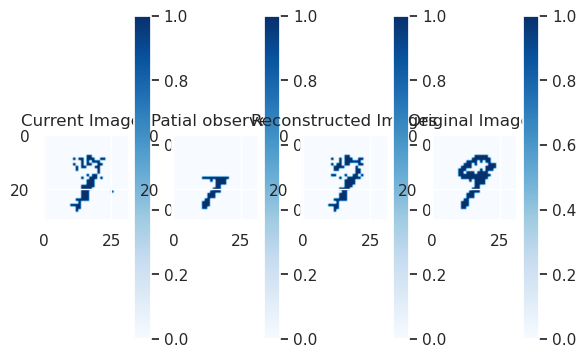

In [30]:
#DEMO
original_images = jnp.squeeze(batch['image'])
original_images = original_images.astype(jnp.float32)
original_images= pad_fn(original_images)

half_height = original_images.shape[1] // 2

images_with_top_half_missing = original_images.copy()
images_with_top_half_missing = images_with_top_half_missing.at[:, :half_height, :].set(jnp.nan)
mask_missing = jnp.isnan(images_with_top_half_missing)

mask_observed = ~mask_missing

batch_rng = jax.random.split(key, BATCH_SIZE) 
model_output: ImageVAEOutput = model_fn(original_images, key=batch_rng)
reconstruction_img = model_output["observation_distribution"].sample(seed=key)
reconstruction_img =jnp.squeeze(reconstruction_img).astype(jnp.float32)#perfect reconstrcution 

    #print(f"original_img:{original_images.shape} recon_img:{reconstruction_img.shape}")

images_refill = update_images_fn(original_images, mask_observed) #orginal img  half replaced 
curr_output: ImageVAEOutput = model_fn(images_refill, key=batch_rng)
current_images = curr_output["observation_distribution"].sample(seed=key)
current_images = jnp.squeeze(current_images).astype(jnp.float32)

plt.subplot(1, 4, 1)
plt.imshow(current_images[0], cmap='Blues', vmin=0, vmax=1)
plt.colorbar()
plt.title("Current Images")

plt.subplot(1, 4, 2)
plt.imshow(images_refill[0], cmap='Blues', vmin=0, vmax=1)
plt.colorbar()
plt.title("Patial observed")

plt.subplot(1, 4, 3)
plt.imshow(reconstruction_img[0], cmap='Blues', vmin=0, vmax=1)
plt.colorbar()
plt.title("Reconstructed Images")

plt.subplot(1, 4, 4)
plt.imshow(original_images[0], cmap='Blues', vmin=0, vmax=1)
plt.colorbar()
plt.title("Original Images")
# """Reconstruction Distortion(Base case trying to achieve)"""

# recon_loss = get_evidence_lower_bound(original_images, model_output)
# recon_loss['distortion'].item()

In [31]:
original_img = original_images[:, None,:,:]
test1 = loss_fn(original_images, model_output)
jnp.mean(test1['distortion'])

Array(0.11863297, dtype=float32)

In [11]:
current_mask = mask_observed

random_images = images_refill
random_mask = mask_observed
test_array = []
update = jit(update)
current_images = images_refill
step = 0
loss_img =  original_images[:, None,:,:]
for _ in range(32*32):
    current_images, current_mask = update(images_refill, original_images, current_images, current_mask, key)
    current_output: ImageVAEOutput = model_fn(current_images, key=batch_rng)
    current_reconstruction = current_output["observation_distribution"].sample(seed=key)
    current_reconstruction = jnp.squeeze(current_reconstruction).astype(jnp.float32)
    loss = loss_fn (loss_img, current_output)
    distortion = jnp.mean(loss["distortion"])
    test_array.append(distortion)
    step += 1
    if step % 1== 0 & step < 20:
        print(distortion)
        # plt.figure()
        # plt.subplot(1, 4, 1)
        # plt.imshow(current_reconstruction[0], cmap='Blues', vmin=0, vmax=1)
        # plt.colorbar()
        # plt.title("Current Images")

        # plt.subplot(1, 4, 2)
        # plt.imshow(current_images[0], cmap='Blues', vmin=0, vmax=1)
        # plt.colorbar()
        # plt.title("Patial observed")

        # plt.subplot(1, 4, 3)
        # plt.imshow(reconstruction_img[0], cmap='Blues', vmin=0, vmax=1)
        # plt.colorbar()
        # plt.title("Reconstructed Images")

        # plt.subplot(1, 4, 4)
        # plt.imshow(original_images[0], cmap='Blues', vmin=0, vmax=1)
        # plt.colorbar()
        # plt.title("Original Images")
        # plt.show()
    if distortion == jnp.mean(test1['distortion']):
        break
steps = jnp.arange(1, step + 1) 
plt.figure()
plt.plot(steps,test_array)    

NameError: name 'mask_observed' is not defined

In [1]:
display_batch_number = 1
batch_counter = 0
log_likelihood = []
full_recon_loss = []
step_numbers = []

random_recon =[]

update = jit(update)
random_update = jit(random_update)

for batch_index, batch in enumerate(test_dataloader):

    original_images = jnp.squeeze(batch['image'])
    original_images = original_images.astype(jnp.float32)
    original_images= pad_fn(original_images)
    half_height = original_images.shape[1] // 2
    images_with_top_half_missing = original_images.copy()
    images_with_top_half_missing = images_with_top_half_missing.at[:, :half_height, :].set(jnp.nan)
    mask_missing = jnp.isnan(images_with_top_half_missing)
    mask_observed = ~mask_missing

    batch_rng = jax.random.split(key, BATCH_SIZE) 
    model_output: ImageVAEOutput = model_fn(original_images, key=batch_rng)
    reconstruction_img = model_output["observation_distribution"].sample(seed=key)
    reconstruction_img =jnp.squeeze(reconstruction_img).astype(jnp.float32)
    """X^p first reconstruction, starting stage"""
    images_refill = update_images_fn(original_images, mask_observed)
    curr_output: ImageVAEOutput = model_fn(images_refill, key=batch_rng)
    current_images = curr_output["observation_distribution"].sample(seed=key)
    current_images = jnp.squeeze(current_images).astype(jnp.float32)
    """"Best Case"""
    loss_img = original_images[:, None,:,:]
    full_loss= loss_fn(loss_img, model_output)
    full_loss = jnp.mean(full_loss['distortion'])
    
    current_images = images_refill
    current_mask = mask_observed

    random_images = images_refill
    random_mask = mask_observed

    steps = 20  #display freq
    step_counter = 0
    
    for _ in range(32*32):
        current_images, current_mask = update(images_refill, original_images, current_images, current_mask, key)
        current_output: ImageVAEOutput = model_fn(current_images, key=batch_rng)
        current_reconstruction = current_output["observation_distribution"].sample(seed=key)
        current_reconstruction = jnp.squeeze(current_reconstruction).astype(jnp.float32)
        loss = loss_fn (loss_img, current_output)
        distortion = jnp.mean(loss["distortion"])
        log_likelihood.append(distortion)


        """Random baseline"""
        random_images, random_mask = random_update(original_images , random_images, random_mask, key)
        random_output: ImageVAEOutput = model_fn(random_images, key=batch_rng)
        rand_reconstruction = random_output["observation_distribution"].sample(seed=key)
        rand_reconstruction = jnp.squeeze(current_reconstruction).astype(jnp.float32)
        rand_loss = loss_fn(loss_img, random_output)
        rand_distrotion = jnp.mean(rand_loss["distortion"])
        random_recon.append(rand_distrotion)
        if batch_index == display_batch_number:
            if step_counter % steps == 0:
                # # print(f"Step {step_counter}:  Log Likelihood = {jnp.mean(new_log_likelihood_recon)}")
                # # print(f"Step {step_counter}:  Random Log Likelihood = {jnp.mean(random_log_likelihood)}")
                # # print(f"Step {step_counter}:  Fully loss= {jnp.mean(fully_loss)}")
                # print(f"Step {step_counter}:  Log Likelihood = {new_log_likelihood_recon[0]}")
                # print(f"Step {step_counter}:  Random Log Likelihood = {random_log_likelihood[0]}")
                # print(f"Step {step_counter}:  Fully loss= {fully_loss[0]}")
                print(distortion)

                if step_counter < 800:
                    plt.subplot(1, 4, 1)
                    plt.imshow(current_reconstruction[0], cmap='Blues', vmin=0, vmax=1)
                    plt.colorbar()
                    plt.title("Current Images")

                    plt.subplot(1, 4, 2)
                    plt.imshow(current_images[0], cmap='Blues', vmin=0, vmax=1)
                    plt.colorbar()
                    plt.title("Patial observed")

                    plt.subplot(1, 4, 3)
                    plt.imshow(reconstruction_img[0], cmap='Blues', vmin=0, vmax=1)
                    plt.colorbar()
                    plt.title("Reconstructed Images")

                    plt.subplot(1, 4, 4)
                    plt.imshow(original_images[0], cmap='Blues', vmin=0, vmax=1)
                    plt.colorbar()
                    plt.title("Original Images")

                    plt.show()
        if distortion == full_loss:
            break
        step_counter += 1
    
    batch_counter += 1
    if batch_counter == 4:
        break
    print(f"batch{batch_counter}")


NameError: name 'jit' is not defined

In [15]:
jnp.array(log_likelihood).shape

(4096,)

In [13]:
num_batches_to_process = batch_counter
reshaped_batches =jnp.array(log_likelihood).reshape(num_batches_to_process, 1024).transpose(1, 0)
combined_batches = reshaped_batches.reshape(1024, num_batches_to_process)
std_dev_each_step = jnp.std(combined_batches, axis=1, keepdims=True)

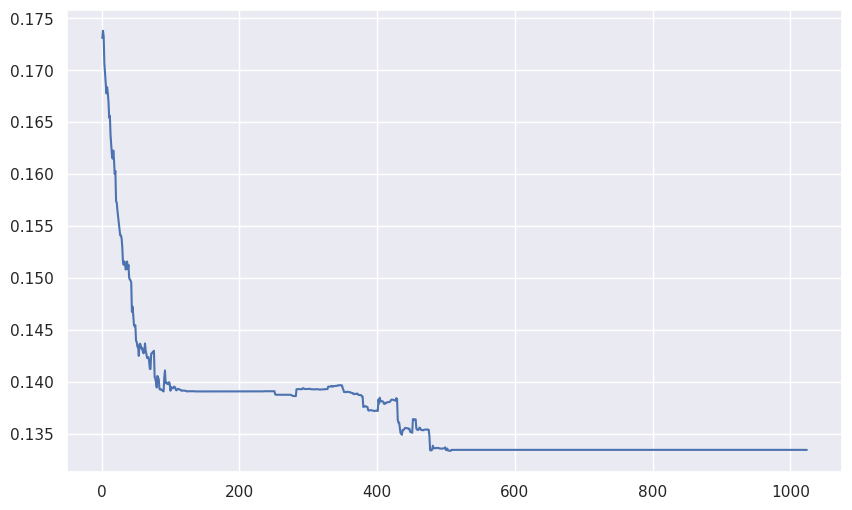

In [14]:
mean_values = jnp.mean(combined_batches, axis=1)
steps = jnp.arange(1, 1025)  
plt.figure(figsize=(10, 6))
plt.plot(steps, mean_values, label='Acquisition Reconstruction Value Line')
plt.show()


In [ ]:

rand_reshaped_batches =jnp.array(random_recon).reshape(num_batches_to_process, 1024).transpose(1, 0)
rand_combined_batches = rand_reshaped_batches.reshape(1024, num_batches_to_process)
rand_std_dev_each_step = np.std(rand_combined_batches, axis=1, keepdims=True)

In [ ]:
mean_values = jnp.mean(combined_batches, axis=1)
rand_values = jnp.mean(rand_combined_batches, axis=1)
full_value = jnp.mean(jnp.array(full_recon_loss))
steps = jnp.arange(1, 1025)  
SD = jnp.std(jnp.array(full_recon_loss))

SE = std_dev_each_step/jnp.sqrt(num_batches_to_process*BATCH_SIZE)
SE_rand = rand_std_dev_each_step/jnp.sqrt(num_batches_to_process*BATCH_SIZE)
SE_full = SD/jnp.sqrt(num_batches_to_process*BATCH_SIZE)

ci = 1.96 * SE.flatten()  # Flatten to ensure it's a 1D array
lower_bound = mean_values - ci
upper_bound = mean_values + ci

ci_rand = 1.96 * SE_rand.flatten()  # Flatten to ensure it's a 1D array
lower_bound_rand = rand_values - ci_rand
upper_bound_rand = rand_values + ci_rand

ci_full = 1.96*SE_full
lower_bound_full = full_value - ci_full
upper_bound_full = full_value + ci_full
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(steps, mean_values, label='Acquisition Reconstruction Value Line')
#plt.plot(712.124)
plt.plot(steps, rand_values, label='Random Acquisition Reconstruction Value Line')

full_value_line = jnp.full_like(jnp.float32(steps), full_value)  # Create an array of full_value repeated
plt.plot(steps, full_value_line, label='Full Reconstruction Value Line')
plt.fill_between(steps, lower_bound, upper_bound, color='gray', alpha=0.2, label='95% CI for Mean Reconstruction Values')
plt.fill_between(steps, lower_bound_rand, upper_bound_rand, color='blue', alpha=0.1, label='95% CI for Random Mean Reconstuction Values')
plt.fill_between(steps, lower_bound_full, upper_bound_full, color='grey', alpha=0.2, label='95% CI for Fully Reconstructed Values')


plt.xlabel('Step Number')
plt.ylabel('Reconstruction Value')
plt.title('Reconstruction Value of Data Points at Each Step')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
rand_values = jnp.mean(rand_combined_batches, axis=1)
rand_values.shape

In [ ]:
#mean_values = jnp.mean(combined_batches, axis=1)
rand_values = jnp.mean(rand_combined_batches, axis=1)
# Create an array for the step numbers
steps = jnp.arange(1, 1025)  # 1024 steps, starting from 1

#SE = std_dev_each_step/jnp.sqrt(num_batches_to_process*BATCH_SIZE)
SE_rand = rand_std_dev_each_step/jnp.sqrt(num_batches_to_process*BATCH_SIZE)

# ci = 1.96 * SE.flatten()  # Flatten to ensure it's a 1D array
# lower_bound = mean_values - ci
# upper_bound = mean_values + ci

ci_rand = 1.96 * SE_rand.flatten()  # Flatten to ensure it's a 1D array
lower_bound_rand = mean_values - ci_rand
upper_bound_rand = mean_values + ci_rand

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(steps, rand_values)
#plt.fill_between(steps, lower_bound, upper_bound, color='gray', alpha=0.2, label='95% Confidence Interval')
#plt.fill_between(steps, lower_bound_rand, upper_bound_rand, color='blue', alpha=0.2, label='95% Confidence Interval')

plt.xlabel('Step Number')
plt.ylabel('Mean Value')
plt.title('Mean Value of Data Points at Each Step')
plt.grid(True)
plt.show()